In [1]:
import torch

# For datasets and data handling
from torchvision import datasets # for pytorch's inbuilt image datasets
import torchvision.transforms as transforms # for transforming images to tensors
from torch.utils.data import Dataset,DataLoader # contains ways to load and handle data

# for neural network architecture
import torch.nn as nn # for creating neural networks
import torch.optim as optim # for optimisation algos
import torch.nn.functional as F # for activation functions


# other miscalleneous libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image




In [2]:
import random
import torchvision

In [3]:
# Loading the dataset
from torchvision.datasets import FashionMNIST

In [4]:
Transformation = transforms.Compose([transforms.ToTensor()])

In [5]:
# Loading the MNIST data
train_data = FashionMNIST(
    root = 'data',
    train = True,
    download=True,
    transform=Transformation
)

test_data = FashionMNIST(
    root = 'data',
    train = False,
    download=True,
    transform=Transformation
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.51MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 163kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.7MB/s]


Label: 9


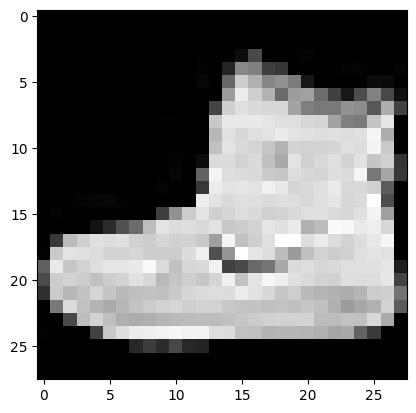

In [6]:
img , label = train_data[0]
plt.imshow(img.squeeze(), cmap="gray")
print(f"Label: {label}")

In [7]:
# Creating the dataset class for Siamese Network
# We need to create the dataset because for siamese dataset you require data in pairs

class SiameseDataset(Dataset):
  def __init__(self,ImageDataset):
    self.ImageDataset = ImageDataset # making the data a class object


  def __getitem__(self,index): # generate a pair of images
    img0,label0 = self.ImageDataset[index] # Find one image for siamese dataset
    # find another image
    same_class = random.randint(0,1) # decides if the pair image should be from same class as the first image
    if same_class ==  1:
      while True:
        img1, label1 = random.choice(self.ImageDataset)
        if label0 == label1:
          break
    else:
      while True:
        img1, label1 = random.choice(self.ImageDataset)
        if label0 != label1:
          break

    return img0, img1, torch.from_numpy(np.array([int(label1 != label0)], dtype=np.float32))

  def __len__(self):
    return len(self.ImageDataset)

In [8]:
# converting into siamese dataset
siamese_train = SiameseDataset(train_data)
siamese_test = SiameseDataset(test_data)

#printing random data
print(siamese_train[89][2])


tensor([1.])


In [9]:
# Creating the neural network architecture
class SiameseNetwork(nn.Module):
  def __init__(self):
    super().__init__() # inherit from __init__ of the nn.Module (generally used just for nn.Module because it is complex than the other classes )

    self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
    )
    self.fc1 = nn.Sequential(
        nn.Linear(256*3*3, 1024), # will recieve a flattened tensor after cnn layers are applied
        nn.ReLU(inplace=True),

        nn.Linear(1024, 256),
        nn.ReLU(inplace=True),
    )

  def forward_ind(self,x): # individual forward functions for each siamese part
    x = self.cnn1(x)
    x = x.view(x.size()[0], -1) # flatten the tensor for the fc1 layers
    x = self.fc1(x)
    return x

  def forward(self, input1, input2):
    output1 = self.forward_ind(input1)
    output2 = self.forward_ind(input2)
    return output1, output2

      # output1 and output2 will be compared by the contrastive loss functions
      # using the Euclidean distance





In [10]:
class contrastive_loss(torch.nn.Module):
  def __init__(self, margin=2.0): # margin is the minimum value you want the euclidean distance to be
    super().__init__()
    self.margin = margin


  def forward(self, output1, output2 , label ):
    euclid_dist = F.pairwise_distance(  output1, output2, keepdim = True)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclid_dist, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclid_dist, min=0.0), 2))
    return loss_contrastive


In [11]:
train_loader = DataLoader(siamese_train, shuffle=True, num_workers=8 ,batch_size=64)
test_loader = DataLoader(siamese_test, shuffle=True, batch_size=64)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
net = SiameseNetwork().cuda()
criterion = contrastive_loss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001 )

In [13]:
counter = []
loss_history = []
iteration_number= 0

for epoch in range(5):

    for i, (img0, img1, label) in enumerate(train_loader, 0):

        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0 :
            print(f"Epoch{epoch}\n loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())



Epoch0
 loss 2.112386465072632

Epoch0
 loss 1.7956297397613525

Epoch0
 loss 1.3436076641082764

Epoch0
 loss 1.4923818111419678

Epoch0
 loss 1.6683396100997925

Epoch0
 loss 1.129117488861084

Epoch0
 loss 0.9430510997772217

Epoch0
 loss 0.8402733206748962

Epoch0
 loss 0.9310178756713867

Epoch0
 loss 0.8036563396453857

Epoch0
 loss 0.7072863578796387

Epoch0
 loss 0.7937923669815063

Epoch0
 loss 0.6369797587394714

Epoch0
 loss 0.6237426400184631

Epoch0
 loss 0.5633864402770996

Epoch0
 loss 0.6291154026985168

Epoch0
 loss 0.502450704574585

Epoch0
 loss 0.3382962942123413

Epoch0
 loss 0.6720473766326904

Epoch0
 loss 0.4487552046775818

Epoch0
 loss 0.5302122831344604

Epoch0
 loss 0.460636168718338

Epoch0
 loss 0.4956133961677551

Epoch0
 loss 0.6477615833282471

Epoch0
 loss 0.6364350318908691

Epoch0
 loss 0.40108048915863037

Epoch0
 loss 0.5867592096328735

Epoch0
 loss 0.5447361469268799

Epoch0
 loss 0.5262082815170288

Epoch0
 loss 0.6088511943817139

Epoch0
 loss 

In [14]:
def show_plot(counter,loss_history):
    plt.plot(counter,loss_history)
    plt.show()

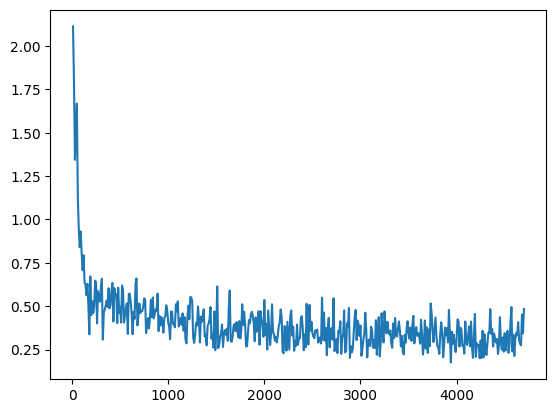

In [15]:
show_plot(counter,loss_history)

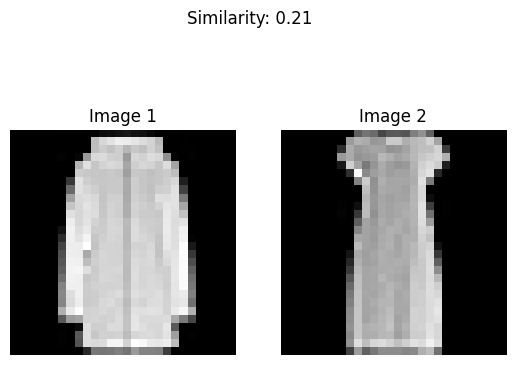

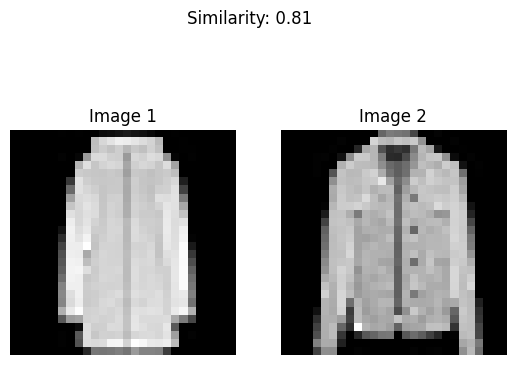

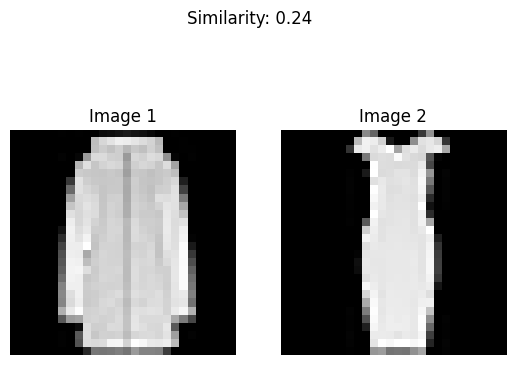

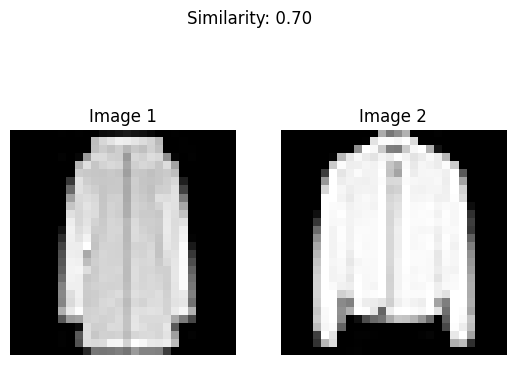

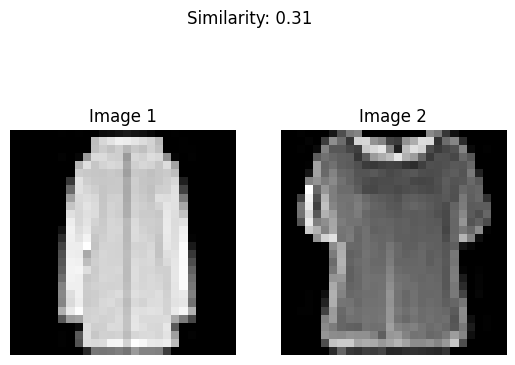

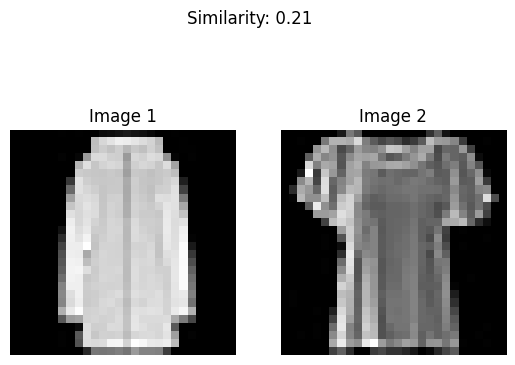

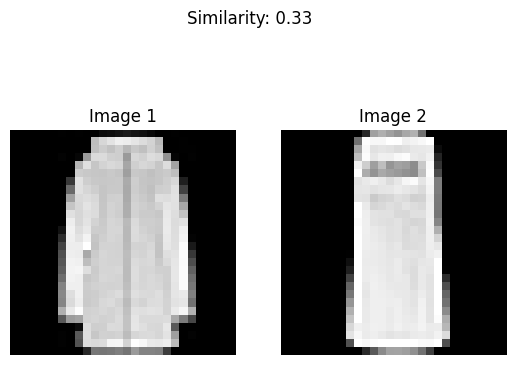

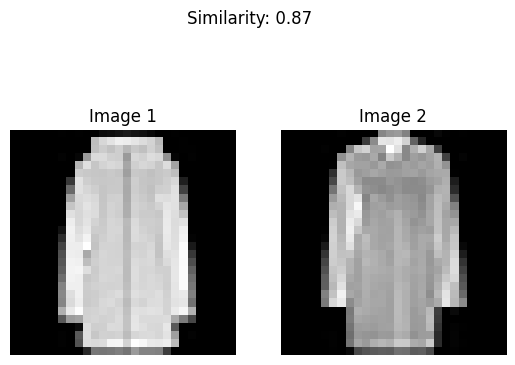

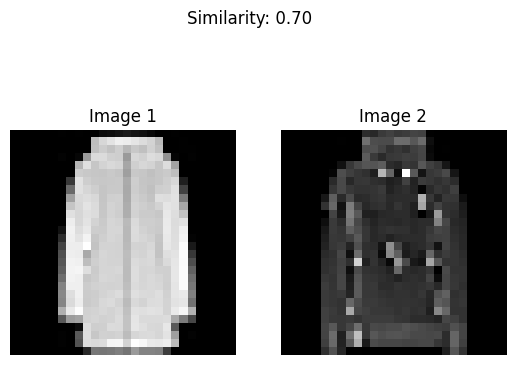

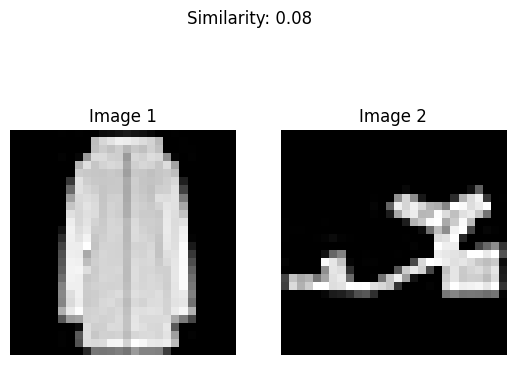

In [23]:
test_loader = DataLoader(siamese_test, num_workers=2, batch_size=1, shuffle=True)
dataiter = iter(test_loader)
x0, _, label1 = next(dataiter)

# Define the class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):

    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    similarity_score = torch.exp(-euclidean_distance)

    # Display the images and similarity score
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(x0.squeeze().cpu().numpy(), cmap="gray")
    ax[0].set_title("Image 1")
    ax[0].axis("off")
    ax[1].imshow(x1.squeeze().cpu().numpy(), cmap="gray")
    ax[1].set_title("Image 2")
    ax[1].axis("off")


    fig.suptitle(f'Similarity: {similarity_score.item():.2f}')
    plt.show()